# Temperature Forecasting
This notebook uses weather timeseries data from Jena, Germany. Weather data is recorded every 10 minutes, with the dataset spanning from 2009-2016. We will be building a model which takes in input data from the past few days to predict what the temperature will be in 24hrs.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers
from keras.optimizers import RMSprop

In [2]:
# Load data
with open('jena_climate_2009_2016.csv') as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


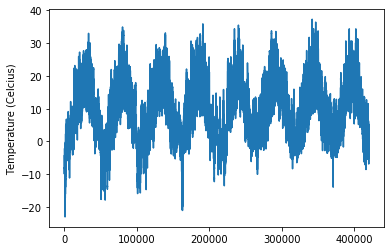

In [3]:
# Parse
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] #Exclude Date Time col
    float_data[i,:] = values

# Plot all temperature data
temp = float_data[:,1]
plt.plot(range(len(lines)), temp)
plt.ylabel('Temperature (Celcius)')
plt.show()

The plot above shows yearly periodicity of temperature which is expected due to seasonal changes.

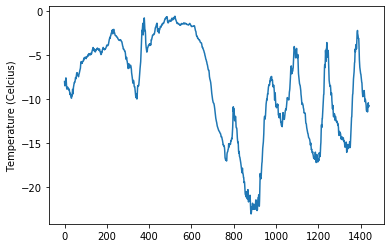

In [4]:
# Temperature - first 10 days
n_tenDay = int(24*60*10/10)
plt.plot(range(n_tenDay), temp[:n_tenDay])
plt.ylabel('Temperature (Celcius)')
plt.show()

We also observe daily periodicity of temperature data. Since the temperature values are more volotile on a per-day basis, it makes daily temperature predictions more challenging.

## Data Preparation

In [5]:
# Normalize data with train set statistics
num_train = 200000
mean = float_data[:num_train].mean(axis=0)
std = float_data[:num_train].std(axis=0)

float_data = (float_data - mean) / std

In [6]:
# Define timeseries data generator
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    '''
    data - data array to sample from
    lookback - # of timesteps back input data goes
    delay - # of timesteps in the future the target is
    min_index / max_index - Index range to draw data from the data array
    shuffle - whether to shuffle data or draw chronologically
    batch_size - sample size generator returns
    step - period in timesteps of which data is sampled (6 = 1 sample per hr) 
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i+batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(row-lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row + delay][1] #index temp col
        yield samples, targets
    

In [38]:
# Construct train / validation / test generators
lookback = 1440   #10 Days input data per sample
step = 6          #1 SAMPLE per hr
delay = 144       #Predict 1 day ahead
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)

val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)

test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

# Generator steps to go through whole data split
train_steps = (200000 - lookback)//batch_size
val_steps = (300000 - 200001 - lookback)//batch_size
test_steps = (len(float_data) - 300001 - lookback)//batch_size

## A Naive Baseline
Before moving on to more complicated machine learning algorithms, we should establish a simple baseline for our algorithm to beat. A simple prediction strategy for this problem would be to predict the temperature 24 hrs ahead to be the same as it is currently.

In [8]:
# Evaluate simple baseline MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1] #Temp of last timestep
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    mae = np.mean(batch_maes)
    print(mae)
    return mae
    
baseline_mae = evaluate_naive_method()

0.2897359729905488


In [9]:
celsius_mae = baseline_mae * std[1] #Undo scaling
print(celsius_mae)

2.564887434980494


The naive baseline achieves an MAE of 2.56 degrees Celcius, which is quite substantial. Now we will attempt to use neural networks to reduce this error.

## MLP Architecture
Before investing more time and resources into more complex network architectures, we will evaluate the performance of a simple feed-forward fully-connected neural net.

In [14]:
# Train basic MLP model
model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20
1551/1551 [==============================] - 31s 20ms/step - loss: 0.5945 - val_loss: 0.3535
Epoch 2/20
1551/1551 [==============================] - 31s 20ms/step - loss: 0.2515 - val_loss: 0.3171
Epoch 3/20
1551/1551 [==============================] - 31s 20ms/step - loss: 0.2319 - val_loss: 0.5107
Epoch 4/20
1551/1551 [==============================] - 31s 20ms/step - loss: 0.2194 - val_loss: 0.4230
Epoch 5/20
1551/1551 [==============================] - 31s 20ms/step - loss: 0.2104 - val_loss: 0.5132
Epoch 6/20
1551/1551 [==============================] - 31s 20ms/step - loss: 0.2044 - val_loss: 0.5484
Epoch 7/20
1551/1551 [==============================] - 31s 20ms/step - loss: 0.1970 - val_loss: 0.2812
Epoch 8/20
1551/1551 [==============================] - 31s 20ms/step - loss: 0.1933 - val_loss: 0.4119
Epoch 9/20
1551/1551 [==============================] - 31s 20ms/step - loss: 0.1904 - val_loss: 0.4280
Epoch 10/20
1551/1551 [==============================] - 31s 20m

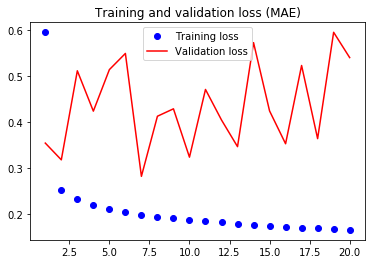

In [15]:
# Plot MAE
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (MAE)')
plt.legend()
plt.show()

We find that the model's MAE achieves similar performance to the naive baseline discussed. This is likely due to the model not having enough capacity and complexity to learn a significantly better predictor. We should try some more complex network architectures.

## A Recurrent Baseline
By using a recurrent architecture, we can exploit the time dependent nature of sequence data. To do so we will use Gated recurrent unit layers (GRUs) which are less computationally intensive to train than LSTMs.

In [18]:
model = models.Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]))) #None accepts Variable length sequences
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),
             loss='mae')

history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20
1551/1551 [==============================] - 641s 413ms/step - loss: 0.2911 - val_loss: 0.1924
Epoch 2/20
1551/1551 [==============================] - 629s 405ms/step - loss: 0.2705 - val_loss: 0.1900
Epoch 3/20
1551/1551 [==============================] - 632s 407ms/step - loss: 0.2559 - val_loss: 0.1889
Epoch 4/20
1551/1551 [==============================] - 621s 401ms/step - loss: 0.2434 - val_loss: 0.1294
Epoch 5/20
1551/1551 [==============================] - 616s 397ms/step - loss: 0.2308 - val_loss: 0.1327
Epoch 6/20
1551/1551 [==============================] - 621s 400ms/step - loss: 0.2177 - val_loss: 0.1482
Epoch 7/20
1551/1551 [==============================] - 620s 400ms/step - loss: 0.2068 - val_loss: 0.1703
Epoch 8/20
1551/1551 [==============================] - 623s 401ms/step - loss: 0.1978 - val_loss: 0.1937
Epoch 9/20
1551/1551 [==============================] - 641s 413ms/step - loss: 0.1888 - val_loss: 0.1591
Epoch 10/20
1551/1551 [=======================

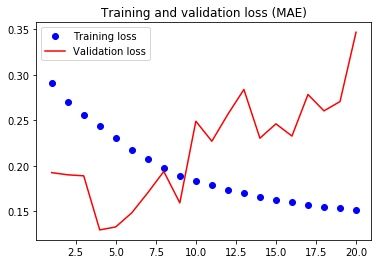

In [19]:
# Plot MAE
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (MAE)')
plt.legend()
plt.show()

In [20]:
celsius_mae = 0.13 * std[1] #Undo scaling
print(celsius_mae)

1.1508248806865997


The recurrent network performs much better on the validation set than the densely connected network, achieving a MAE as low as 0.13 (equivalent to 1.15 deg Cel). The network however begins overfitting very quickly during training after only a few epochs.

### Controlling Overfit
To mitigate the recurrent network overfitting, we can use recurrent dropout to specify the dropout rate of recurrent units at each timestep. We will train for more epochs since dropout typically makes the network take longer to converge.

In [29]:
model = models.Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     implementation=1,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/40
1551/1551 [==============================] - 633s 408ms/step - loss: 0.3206 - val_loss: 0.3173
Epoch 2/40
1551/1551 [==============================] - 629s 405ms/step - loss: 0.2988 - val_loss: 0.4535
Epoch 3/40
1551/1551 [==============================] - 628s 405ms/step - loss: 0.2899 - val_loss: 0.4413
Epoch 4/40
1551/1551 [==============================] - 631s 407ms/step - loss: 0.2851 - val_loss: 0.3599
Epoch 5/40
1551/1551 [==============================] - 629s 405ms/step - loss: 0.2812 - val_loss: 0.3637
Epoch 6/40
1551/1551 [==============================] - 628s 405ms/step - loss: 0.2758 - val_loss: 0.3976
Epoch 7/40
1551/1551 [==============================] - 628s 405ms/step - loss: 0.2742 - val_loss: 0.3012
Epoch 8/40
1551/1551 [==============================] - 627s 404ms/step - loss: 0.2718 - val_loss: 0.2392
Epoch 9/40
1551/1551 [==============================] - 627s 404ms/step - loss: 0.2699 - val_loss: 0.2736
Epoch 10/40
1551/1551 [=======================

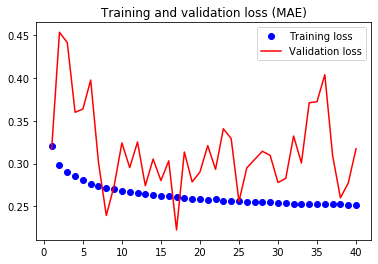

In [30]:
# Plot MAE
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (MAE)')
plt.legend()
plt.show()

The dropout layers effectively reduced overfitting over a greater number of iterations, however the model appears to be struggling to reduce error. We can increase model complexity by adding more GRU layers to reduce error further while maintaining the dropout layers.

### Stacked GRU with dropout

In [32]:
model = models.Sequential()
model.add(layers.GRU(
    32,
    dropout=0.1,
    recurrent_dropout=0.5,
    return_sequences=True, #Set to true since GRUs being stacked
    input_shape=(None, float_data.shape[-1]),
    implementation=1
))
model.add(layers.GRU(
    64,
    activation='relu',
    dropout=0.1,
    recurrent_dropout=0.5,
    implementation=1
))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/40
1551/1551 [==============================] - 1326s 855ms/step - loss: 0.3158 - val_loss: 0.1552
Epoch 2/40
1551/1551 [==============================] - 1316s 848ms/step - loss: 0.2953 - val_loss: 0.1255
Epoch 3/40
1551/1551 [==============================] - 1314s 847ms/step - loss: 0.2868 - val_loss: 0.1323
Epoch 4/40
1551/1551 [==============================] - 1563s 1s/step - loss: 0.2819 - val_loss: 0.1036
Epoch 5/40
1551/1551 [==============================] - 1820s 1s/step - loss: 0.2769 - val_loss: 0.0742
Epoch 6/40
1551/1551 [==============================] - 1837s 1s/step - loss: 0.2732 - val_loss: 0.1019
Epoch 7/40
1551/1551 [==============================] - 1701s 1s/step - loss: 0.2691 - val_loss: 0.0919
Epoch 8/40
1551/1551 [==============================] - 1717s 1s/step - loss: 0.2670 - val_loss: 0.0984
Epoch 9/40
1551/1551 [==============================] - 1773s 1s/step - loss: 0.2643 - val_loss: 0.0808
Epoch 10/40
1551/1551 [==============================] 

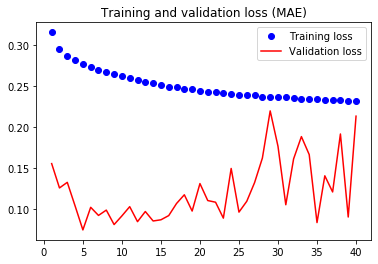

In [33]:
# Plot MAE
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (MAE)')
plt.legend()
plt.show()

In [34]:
celsius_mae = 0.074 * std[1] #Undo scaling
print(celsius_mae)

0.6550849320831413


From the plots, we see that the stacked GRU architecture achieved a MAE of 0.074 after 5 epochs, which is equivalent to 0.66 deg Celcius.